<a href="https://colab.research.google.com/github/itrail/faceMaskDetection/blob/main/faceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#załączenie koniecznych bibliotek tensorflow (do deep learning) i keras (do modelowania sieci neuronowych)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator #do kopiowania zdjecia z lekkimi modyfikacjami aby miec więcej próbek do uczenia
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#ustalenie połaczenia z dyskiem google

from google.colab import drive
drive.mount('/content/drive')
! ls "/content/drive/My Drive"

In [ ]:
#skopiowanie skompresowanych danych do uczenia, walidacji oraz testowania sieci neruronowej

! cp "/content/drive/My Drive/archive.zip" "archive.zip"

In [ ]:
#rozpakowanie archiwum z danymi
! unzip archive.zip

In [ ]:
#wskazanie lokalizacji danych do trenowania, walidacji i testów

main_dir = "/content/New Masks Dataset"
train_dir = os.path.join(main_dir,'Train')
test_dir = os.path.join(main_dir,'Test')
valid_dir = os.path.join(main_dir,'Validation')

#wskazanie lokalizacji danych z oboma przypadkami do uczenia sie 

train_mask_dir = os.path.join(train_dir,'Mask')
train_nomask_dir = os.path.join(train_dir,'Non Mask')

In [ ]:
#testowe wypisanie nazw 10 przykładów zdjęc z maseczka i bez

train_mask_names = os.listdir(train_mask_dir)
print(train_mask_names[:10])

train_nomask_names = os.listdir(train_nomask_dir)
print(train_nomask_names[:10])

['1058.jpg', '1154.jpg', '0168.png', '1107.jpg', '0779.jpg', '0129.png', '0750.jpg', '1135.jpg', '1346.jpg', '0091.jpg']
['125.jpg', '309.jpg', '129.jpg', '225.jpg', '152.jpg', '92.jpg', '197.jpg', '48.jpg', '107.jpg', '141.jpg']


['/content/New Masks Dataset/Train/Mask/1058.jpg', '/content/New Masks Dataset/Train/Mask/1154.jpg', '/content/New Masks Dataset/Train/Mask/0168.png', '/content/New Masks Dataset/Train/Mask/1107.jpg', '/content/New Masks Dataset/Train/Mask/0779.jpg', '/content/New Masks Dataset/Train/Mask/0129.png', '/content/New Masks Dataset/Train/Mask/0750.jpg', '/content/New Masks Dataset/Train/Mask/1135.jpg']
['/content/New Masks Dataset/Train/Non Mask/125.jpg', '/content/New Masks Dataset/Train/Non Mask/309.jpg', '/content/New Masks Dataset/Train/Non Mask/129.jpg', '/content/New Masks Dataset/Train/Non Mask/225.jpg', '/content/New Masks Dataset/Train/Non Mask/152.jpg', '/content/New Masks Dataset/Train/Non Mask/92.jpg', '/content/New Masks Dataset/Train/Non Mask/197.jpg', '/content/New Masks Dataset/Train/Non Mask/48.jpg']


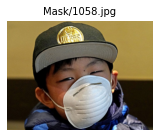

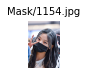

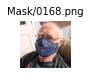

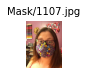

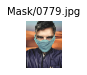

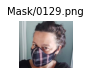

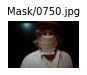

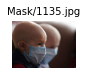

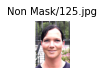

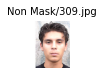

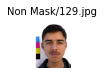

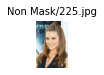

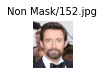

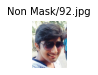

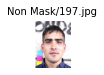

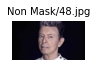

In [ ]:
#testowe wyświetlenie 8 zdjęc z maseczkami i 8 bez maseczki

import matplotlib.image as mpimg
nrows = 4
ncols = 4
plt.figure(figsize=(12,12)) 

mask_pic = []
for i in train_mask_names[0:8]:
  mask_pic.append(os.path.join(train_mask_dir,i))

nomask_pic = []
for i in train_nomask_names[0:8]:
  nomask_pic.append(os.path.join(train_nomask_dir,i))

print(mask_pic)
print(nomask_pic)

merged_list = mask_pic + nomask_pic

for i in range(0,len(merged_list)):
  data = merged_list[i].split("/",4)[4]
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')
  image = mpimg.imread(merged_list[i])
  sp.set_title(data, fontsize=10)
  plt.imshow(image, cmap="gray")

  plt.show()

In [ ]:
#modyfikacja posiadanych danych tak by zyskać jeszcze więcej danych do uczenia

train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, rotation_range= 40, horizontal_flip= True)
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size =32, class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size = 32, class_mode = 'binary')
valid_generator = validation_datagen.flow_from_directory(valid_dir, target_size=(150,150), batch_size = 32, class_mode = 'binary')

In [ ]:
#sprawdzenie stanów wyjściowych sieci neuronowej

train_generator.class_indices

{'Mask': 0, 'Non Mask': 1}

In [ ]:
#sprawdzenie formatu danych wejściowych

train_generator.image_shape

(150, 150, 3)

In [ ]:
#uzycie modelu sekwencyjnego

model = Sequential()

model.add(Conv2D(32, (3,3), padding="SAME", activation="relu", input_shape=(150, 150, 3)))
#dzielimy obraz na 32 mniejsze, szczegóły zapisujemy do macierzy 3x3, za pomocą braku paddingu nie tracimy żadnych danych pomiędzy mniejszymi częsciami obrazu
#aktywacja nieliniowymi funkcjami, a dane wejsciowe to obraz 150x150 w systemie barw rgb

model.add(MaxPooling2D(pool_size=(2,2)))
#wycianmy tylko częśc, która nas interesuje aby przyspieszyc proces uczenia
model.add(Dropout(0.5))
#wycofanie połowy neuronów aby uniknąć przeuczenia

model.add(Conv2D(64, (3,3), padding="SAME", activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0

In [ ]:
#kompilacja sieci neuronowej wraz z optymalizacją i oczekiwaniem wyniku w postaci binarnej funkcji straty krzyżowej entropii

model.compile(Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
#rozpoczęcie procesu uczenia neuronów w 30 cyklach(epokach) z wykorzystaniem danych walidacyjnych

history = model.fit(train_generator, epochs= 30, validation_data= valid_generator)

Epoch 1/30
19/19 [==============================] - 13s 682ms/step - loss: 3.7832 - accuracy: 0.5857 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/30
19/19 [==============================] - 12s 651ms/step - loss: 0.6810 - accuracy: 0.5479 - val_loss: 0.6809 - val_accuracy: 0.6111
Epoch 3/30
19/19 [==============================] - 12s 641ms/step - loss: 0.5423 - accuracy: 0.7280 - val_loss: 0.5490 - val_accuracy: 0.8072
Epoch 4/30
19/19 [==============================] - 12s 642ms/step - loss: 0.3857 - accuracy: 0.8599 - val_loss: 0.4642 - val_accuracy: 0.8235
Epoch 5/30
19/19 [==============================] - 12s 641ms/step - loss: 0.3201 - accuracy: 0.8884 - val_loss: 0.4338 - val_accuracy: 0.8595
Epoch 6/30
19/19 [==============================] - 12s 650ms/step - loss: 0.2908 - accuracy: 0.8892 - val_loss: 0.3373 - val_accuracy: 0.8856
Epoch 7/30
19/19 [==============================] - 12s 640ms/step - loss: 0.2874 - accuracy: 0.8875 - val_loss: 0.3762 - val_accuracy: 0.8791

In [ ]:
#sprawdzenie zawartości sieci

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

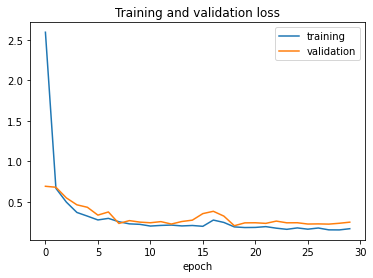

In [ ]:
#wykreslenie strat podczas nauki i walidacji

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and validation loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

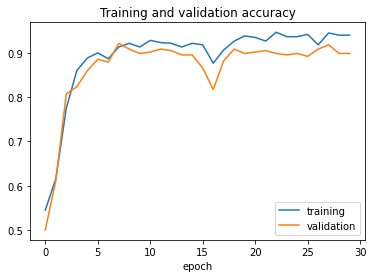

In [ ]:
#wykreslenie precyzji podczas nauki oraz walidacji

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and validation accuracy')
plt.xlabel('epoch')

In [ ]:
#poinformaowanie o wyniku testu straty oraz precyzji nauczonej sieci

test_loss, test_acc = model.evaluate(test_generator)
print("Test loss: {}, Test accuracy: {}".format(test_loss, test_acc))

4/4 [==============================] - 1s 303ms/step - loss: 0.2236 - accuracy: 0.8800
Test loss: 0.2235751897096634, Test accuracy: 0.8799999952316284


Saving morgan.jpg to morgan (1).jpg
Nazwa pliku: morgan.jpg


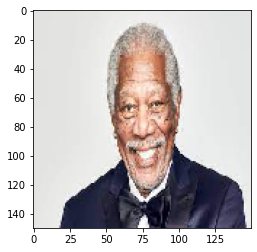

Brak maseczki


In [ ]:
#próba działania sieci na zdjęciach z dysku użytkownika

from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()
for fname in uploaded.keys():
  img_path = "/content/"+fname
  img = image.load_img(img_path, target_size=(150, 150))
  images = image.img_to_array(img)
  images = np.expand_dims(images, axis=0)
  prediction = model.predict(images)
  print("Nazwa pliku: " + fname)
  plt.imshow(img, cmap="gray")

  plt.show()
  if prediction == 0:
    print("Maseczka na twarzy")
  else:
    print("Brak maseczki")

In [ ]:
#zapisanie stworzonego modelu sieci neuronowej

model.save("model.h5")